In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import pandas as pd
from src.tables import MapTable, df_to_tmp_table, df_to_table, get_machines, get_offers, AVG_COLS
from src.preprocess import preprocess
from src.utils import get_tables, get_tbl_info, table_to_df, time_utc_now, np_min_chunk, df_na_vals
import seaborn as sns
import logging

In [3]:
conn = sqlite3.connect('../data/vast.db')
first = conn.execute('SELECT timestamp FROM reliability_ts LIMIT 1').fetchall()[0][0]
last = conn.execute('SELECT timestamp FROM reliability_ts ORDER BY ROWID DESC LIMIT 1').fetchall()[0][0]
print(pd.to_timedelta((last - first) * 1e9))
conn.close()

8 days 01:45:43


In [4]:
df = get_machines().set_index('machine_id')

In [5]:
df_na_vals(df[AVG_COLS])

disk_bw         ->       Missing values: 1 (0.07%)
gpu_mem_bw      ->       Missing values: 0 (0.00%)
pcie_bw         ->       Missing values: 0 (0.00%)
dlperf          ->       Missing values: 0 (0.00%)
score           ->       Missing values: 0 (0.00%)


[]

In [6]:
df.pcie_bw

machine_id
12423    19.7
12422    25.0
12421    12.5
12420    19.5
12418    19.7
         ... 
301       5.8
283       5.7
275       5.8
274       5.5
162      12.5
Name: pcie_bw, Length: 1357, dtype: float64

In [7]:
df.query('gpu_name == "RTX 4090"')[AVG_COLS]
df[AVG_COLS]

,disk_bw,gpu_mem_bw,pcie_bw,dlperf,score
machine_id,,,,,
12423,NaN,767.0,19.7,0.000000,0.000000
12422,1124.130830,745.5,25.0,25.029561,11.237007
12421,321.000000,632.6,12.5,39.872396,22.283248
12420,2951.859325,768.4,19.5,28.110301,11.724895
12418,4348.290033,844.9,19.7,29.536090,12.308916
...,...,...,...,...,...
301,3017.759248,337.8,5.8,50.409591,55.132643
283,177.000000,187.2,5.7,19.623176,41.764369
275,1661.000000,213.0,5.8,27.921954,49.994712


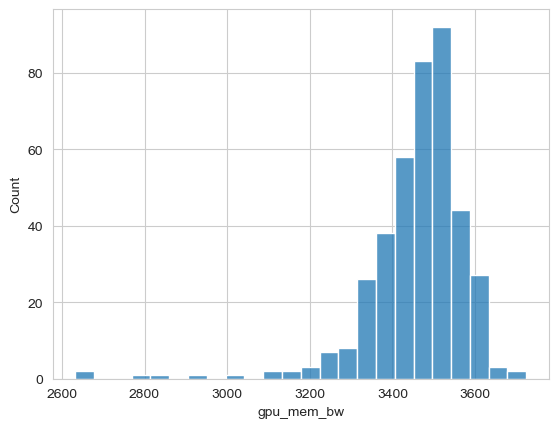

In [18]:
# sns.histplot(df.query('gpu_name == "RTX 4090"'), x='pcie_bw', bins=24);
# sns.histplot(df.query('gpu_name == "RTX 4090"'), x='disk_bw');
sns.histplot(df.query('gpu_name == "RTX 4090"'), x='gpu_mem_bw', bins=24);
# df.query('gpu_name == "RTX 4090"').disk_bw.hist();

In [23]:
df.disk_bw.astype(int)

machine_id
12388     364
12387     308
12386    1230
12385    6618
12384     792
         ... 
301      3193
283       168
275      1563
274      1641
162      1710
Name: disk_bw, Length: 1337, dtype: int32

In [4]:
import os
os.getcwd()

'C:\\Users\\ergot\\DataspellProjects\\vast-stats\\notebooks'

In [40]:
_ = get_offers()

In [20]:
df = get_machines()
# preprocess(df)

In [27]:
df.chunks[df.chunks.apply(len) == 7]

30      [{'size': 2, 'offerId': 6703581, 'rentable': T...
44      [{'size': 1, 'offerId': 6701408, 'rentable': F...
71      [{'size': 1, 'offerId': 6684674, 'rentable': F...
92      [{'size': 1, 'offerId': 6649884, 'rentable': F...
116     [{'size': 1, 'offerId': 6719275, 'rentable': T...
                              ...                        
1232    [{'size': 1, 'offerId': 6499199, 'rentable': F...
1241    [{'size': 1, 'offerId': 5743626, 'rentable': F...
1244    [{'size': 1, 'offerId': 6620807, 'rentable': F...
1245    [{'size': 1, 'offerId': 6553529, 'rentable': F...
1247    [{'size': 1, 'offerId': 6570104, 'rentable': F...
Name: chunks, Length: 169, dtype: object

In [36]:
df.chunks[331]

[{'size': 2, 'offerId': 6592467, 'rentable': True},
 {'size': 2, 'offerId': 6592468, 'rentable': True},
 {'size': 2, 'offerId': 6592470, 'rentable': True},
 {'size': 2, 'offerId': 6592473, 'rentable': True},
 {'size': 4, 'offerId': 6592469, 'rentable': True},
 {'size': 4, 'offerId': 6592471, 'rentable': True},
 {'size': 8, 'offerId': 6592472, 'rentable': True}]

In [43]:
def pd_min_chunks(chunks):        
    gpu_chunks = [d['size'] for d in chunks]
    min_chunk = gpu_chunks[0]
    
    # correction for the case where whole machine size is not a multiple of min_chunk
    # in this case, there is always a single remainder chunk which is smaller than actual min_chunk
    # examples: [1 2 2 2 3 4 7] [1 2 3], actual min_chunk is 2
    #           [3 4 7], actual min_chunk is 4
    if gpu_chunks.count(min_chunk) == 1 and len(gpu_chunks) >= 3:
        min_chunk = gpu_chunks[1]
    
    chunks = [c for c in chunks if c['size'] <= min_chunk]
    return chunks

In [62]:
df.query('machine_id == 8506').static_ip

888    True
Name: static_ip, dtype: bool

In [57]:
df.query('machine_id == 8506').chunks.apply(pd_min_chunks)

888    [{'size': 4, 'offerId': 6716663, 'rentable': F...
Name: chunks, dtype: object

In [53]:
df.chunks[66]

[{'size': 1, 'offerId': 6677215, 'rentable': True},
 {'size': 1, 'offerId': 6677216, 'rentable': True},
 {'size': 1, 'offerId': 6677217, 'rentable': True},
 {'size': 1, 'offerId': 6677218, 'rentable': True},
 {'size': 1, 'offerId': 6677222, 'rentable': True},
 {'size': 1, 'offerId': 6677223, 'rentable': True},
 {'size': 1, 'offerId': 6677224, 'rentable': True},
 {'size': 1, 'offerId': 6677228, 'rentable': True},
 {'size': 2, 'offerId': 6677219, 'rentable': True},
 {'size': 2, 'offerId': 6677220, 'rentable': True},
 {'size': 2, 'offerId': 6677226, 'rentable': True},
 {'size': 2, 'offerId': 6677229, 'rentable': True},
 {'size': 4, 'offerId': 6677221, 'rentable': True},
 {'size': 4, 'offerId': 6677225, 'rentable': True},
 {'size': 8, 'offerId': 6677227, 'rentable': True}]

In [49]:
df.chunks.apply(len)

0        1
1        1
2        5
3        1
4        1
        ..
1248     1
1249    15
1250    15
1251    15
1252     1
Name: chunks, Length: 1253, dtype: int64

In [25]:
df.chunks[280]

[{'size': 1, 'offerId': 6719455, 'rentable': True},
 {'size': 1, 'offerId': 6719457, 'rentable': True},
 {'size': 1, 'offerId': 6719460, 'rentable': True},
 {'size': 1, 'offerId': 6719461, 'rentable': True},
 {'size': 1, 'offerId': 6719463, 'rentable': True},
 {'size': 1, 'offerId': 6719464, 'rentable': True},
 {'size': 1, 'offerId': 6719468, 'rentable': True},
 {'size': 1, 'offerId': 6719470, 'rentable': True},
 {'size': 1, 'offerId': 6719471, 'rentable': True},
 {'size': 1, 'offerId': 6719472, 'rentable': True},
 {'size': 1, 'offerId': 6719474, 'rentable': True},
 {'size': 1, 'offerId': 6719475, 'rentable': True},
 {'size': 1, 'offerId': 6719479, 'rentable': True},
 {'size': 1, 'offerId': 6719480, 'rentable': True},
 {'size': 2, 'offerId': 6719458, 'rentable': True},
 {'size': 2, 'offerId': 6719465, 'rentable': True},
 {'size': 2, 'offerId': 6719466, 'rentable': True},
 {'size': 2, 'offerId': 6719469, 'rentable': True},
 {'size': 2, 'offerId': 6719476, 'rentable': True},
 {'size': 2,

In [8]:
conn = sqlite3.connect('../test/test.db')

In [13]:
df_to_tmp_table(df[:2], 'machines', conn)

[[0, [{'size': 1, 'offerId': 6719359, 'rentable': True}], 750, 32, 'Xeon® E5-2683 v4 ', 15, 100, '12.0', 100, 197, 'Western WDC', 6651, 672, 100, '525.125.06', 1696032000, 1, 16, 368, 'RTX 2070S', 8192, 1, 3483, 0, 0, 20, 0, 29, 12042, 80, 1, 'X99', 1, 0, 3, 114, '174.95.185.54', 9890, 1881, 1, 450, 11, 0, 1691646537, 'CA'], [0, [{'size': 1, 'offerId': 6719237, 'rentable': True}], 860, 12, '11th Gen Core™ i5-11600K ', 31, 100, '12.0', 100, 2172, 'nvme', 372, 3278, 190, '525.125.06', 1694822400, 0, 16, 768, 'RTX 3090', 24576, 1, 74292, 0, 0, 2, 0, 3, 12041, 172, 1, 'PRIME Z590', 1, 0, 3, 118, '134.215.109.213', 5727, 1053, 1, 150, 44, 0, 1691646537, 'US']]


InterfaceError: Error binding parameter 1 - probably unsupported type.

In [1]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('../vast.db')
cursor = conn.cursor()

# Get list of table names
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()

# Iterate through tables and check for NULL values
for table in tables:
    table_name = table[0]

    # Get list of column names in the table
    columns = cursor.execute(f"PRAGMA table_info({table_name})").fetchall()

    for column in columns:
        column_name = column[1]
        query = f"SELECT * FROM {table_name} WHERE {column_name} IS NULL"
        null_rows = cursor.execute(query).fetchall()
        if len(null_rows) > 0:
            print(f"Table '{table_name}', Column '{column_name}' has NULL values.")

# Close the connection
conn.close()

Table 'avg_ts', Column 'disk_bw_std' has NULL values.
Table 'avg_ts', Column 'gpu_mem_bw_std' has NULL values.
Table 'avg_ts', Column 'pcie_bw_std' has NULL values.
Table 'avg_ts', Column 'dlperf_std' has NULL values.
Table 'avg_ts', Column 'score_std' has NULL values.


In [ ]:
df = pd.DataFrame()

In [5]:
import sqlite3
import os
import numpy as np

DB_PATH = '../data'

# Create directories for databases if they don't exist
if not os.path.exists(DB_PATH):
    os.makedirs(DB_PATH)

# Function to create and populate a database with the specified data type and range
def create_and_populate_db(db_name, data_type, value_range, size=10000):
    db_path = os.path.join(DB_PATH, db_name)

    conn = sqlite3.connect(db_path)

    conn.execute(f"CREATE TABLE data (value {data_type})")

    # Generate and insert values within the specified range
    values = np.random.randint(*value_range, size=size) if data_type == 'INTEGER' else np.random.uniform(*value_range, size=size).round(1)
    rows = [(value,) for value in values]
    
    # print(rows[:3])
    # conn.executemany("INSERT INTO data (value) VALUES (?)", rows)
    
    for value in values:
        conn.execute(f"INSERT INTO data (value) VALUES ({value})")

    conn.commit()  
    conn.execute("VACUUM")          
    conn.close()

# delete exiting db's
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    os.remove(db_path)


# Create and populate the databases
create_and_populate_db('integer_db.sqlite', 'INTEGER', (0, 1000))  
create_and_populate_db('integer_non_null_db.sqlite', 'INTEGER NOT NULL', (0, 1000))
create_and_populate_db('real_db.sqlite', 'REAL', (0, 100))            
create_and_populate_db('real_non_null_db.sqlite', 'REAL NOT NULL', (0, 100))            

# Print database sizes
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    db_size = os.path.getsize(db_path) / (1024 * 1024)  # Size in MB
    print(f"Database '{db_name}' size: {db_size:.2f} MB")

Database 'integer_db.sqlite' size: 0.09 MB
Database 'integer_non_null_db.sqlite' size: 0.15 MB
Database 'real_db.sqlite' size: 0.14 MB
Database 'real_non_null_db.sqlite' size: 0.14 MB


In [80]:
import os
import psutil

The CPU usage is :  0.16666666666666669


In [88]:
# Getting loadover15 minutes
load1, load5, load15 = psutil.getloadavg()

cpu_usage = (load15/os.cpu_count()) * 100

print("The CPU usage is : ", load1)

The CPU usage is :  0.05


In [89]:
import platform
platform.processor()

'AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD'

In [91]:
psutil.cpu_freq()

scpufreq(current=3593.0, min=0.0, max=3593.0)

In [93]:
psutil.cpu_percent(interval=1)

6.1

In [76]:
os.cpu_count()

24

In [28]:
conn.execute('CREATE TABLE tmp (id, mid)')

OperationalError: table tmp already exists

In [32]:
conn.execute('INSERT INTO tmp VALUES (1, 2)').fetchall()
# conn.close()

[]

In [35]:
conn.execute('DROP TABLE IF EXISTS map_tbl').fetchall()

[]

In [37]:
conn.commit()
get_tables(conn)

[]

In [42]:
conn.close()

In [9]:
conn.execute('DROP TABLE IF EXISTS map_tbl')
map_tbl = MapTable(
    'map_tbl',
    'tmp',
    ['id', 'mid']
)
map_tbl.init_db(conn)
assert 'map_tbl' in get_tables(conn)
info = get_tbl_info('map_tbl', conn)
assert info.loc[info.name == 'id', 'pk'].all()
assert (info.name == 'mid').any()

In [54]:
(info.name == 'mid').any()

True

In [46]:
all(info.loc[info.name == 'id', 'pk'])

True

In [69]:
get_tables(conn)

['host_machine_map',
 'online_ts',
 'online_snp',
 'reliability_ts',
 'reliability_snp',
 'hosting_type_ts',
 'hosting_type_snp',
 'static_ip_ts',
 'static_ip_snp',
 'end_date_ts',
 'end_date_snp',
 'compute_cap_ts',
 'compute_cap_snp',
 'total_flops_ts',
 'total_flops_snp',
 'has_avx_ts',
 'has_avx_snp',
 'cpu_cores_ts',
 'cpu_cores_snp',
 'cpu_ram_ts',
 'cpu_ram_snp',
 'disk_space_ts',
 'disk_space_snp',
 'num_gpus_ts',
 'num_gpus_snp',
 'pci_gen_ts',
 'pci_gen_snp',
 'gpu_lanes_ts',
 'gpu_lanes_snp',
 'gpu_ram_ts',
 'gpu_ram_snp',
 'bw_nvlink_ts',
 'bw_nvlink_snp',
 'verification_ts',
 'verification_snp',
 'storage_cost_ts',
 'storage_cost_snp',
 'inet_up_cost_ts',
 'inet_up_cost_snp',
 'inet_down_cost_ts',
 'inet_down_cost_snp',
 'credit_discount_max_ts',
 'credit_discount_max_snp',
 'cpu_name_ts',
 'cpu_name_snp',
 'disk_name_ts',
 'disk_name_snp',
 'mobo_name_ts',
 'mobo_name_snp',
 'gpu_name_ts',
 'gpu_name_snp',
 'cuda_max_good_ts',
 'cuda_max_good_snp',
 'driver_version_ts',
 

In [70]:
table_to_df('reliability_ts', conn)

name,machine_id,reliability,timestamp
0,11815,6000,1690464352
1,11814,6000,1690464352
2,11813,5727,1690464352
3,11812,9026,1690464352
4,11811,7779,1690464352
...,...,...,...
37259,5456,8515,1690522270
37260,4795,8063,1690522270
37261,4558,9821,1690522270
37262,4557,9848,1690522270


In [71]:
conn.close()

In [57]:
machines = get_machines()
preprocess(machines)
df_to_tmp_table(machines, 'tmp_machines', conn)

In [61]:
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bw_nvlink             1209 non-null   int32  
 1   compute_cap           1209 non-null   int64  
 2   cpu_cores             1209 non-null   int32  
 3   cpu_name              1209 non-null   object 
 4   cpu_ram               1209 non-null   int32  
 5   credit_balance        1209 non-null   object 
 6   credit_discount       1209 non-null   object 
 7   credit_discount_max   1209 non-null   int32  
 8   cuda_max_good         1209 non-null   object 
 9   direct_port_count     1209 non-null   int64  
 10  discount_rate         1209 non-null   float64
 11  discounted_dph_total  1209 non-null   float64
 12  discounted_hourly     1209 non-null   int64  
 13  disk_bw               1209 non-null   float64
 14  disk_name             1209 non-null   object 
 15  disk_space           

In [47]:
name = 'reliability2'
table = NewTS(
    name,
    'tmp_machines',
    ['machine_id', name]
)

In [48]:
table.init_db(conn)

In [52]:
table.write_db(conn)

[autoreload of _pydevd_bundle.pydevd_frame failed: Traceback (most recent call last):
  File "C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\IPython\extensions\autoreload.py", line 471, in superreload
    module = reload(module)
  File "C:\Users\ergot\mambaforge\envs\ml\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 612, in _exec
  File "<frozen importlib._bootstrap>", line 556, in _init_module_attrs
  File "<frozen importlib._bootstrap>", line 397, in cached
  File "<frozen importlib._bootstrap_external>", line 513, in _get_cached
  File "<frozen importlib._bootstrap_external>", line 406, in cache_from_source
  File "<frozen importlib._bootstrap_external>", line 134, in _path_split
  File "<frozen importlib._bootstrap_external>", line 134, in <